# Modern convolutional networks for computer vision

By now we know the sequential way of building networks very well, and it's time to fully utilise the Keras _functional_ API.

Most modern neural networks are not sequential, but have connections between layers that are not neighbours. We will build a few of the noteworthy modern network architectures here, and you are free to add your own ones as well.

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

Let's use the CIFAR-10 data for this exercise.

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

image_shape = X_train.shape[1:]
print('image shape:', image_shape)

image shape: (32, 32, 3)


## Residual networks (ResNets)

We want to replicate the model used in this [research paper](https://arxiv.org/pdf/1512.03385), which is called a _residual network_. The one on the right-hand side here is our target (look at Fig 3 in the article for higher resolution):

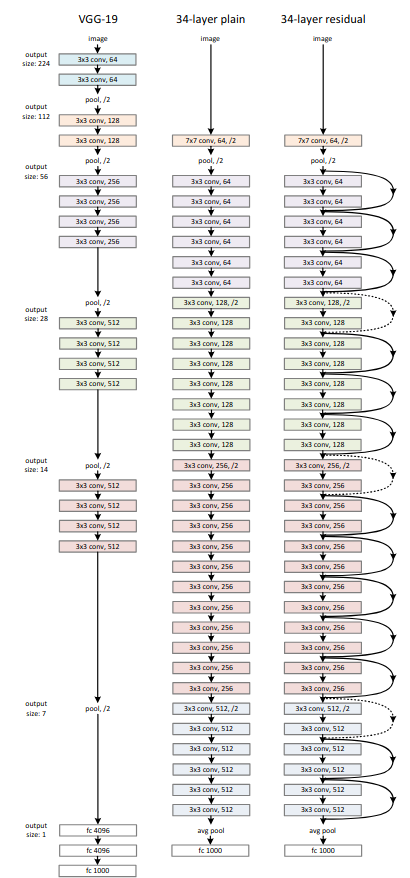

The point of the article is to show that the two sequential network on the left side and the middle og the figure are very hard to train due to **vanishing gradients**. The proposed model on the right has these extra connection where data is flowing _past_ every other layer, which makes sure there is some signal flowing through the model. These are called _residual_ connections, which has given name to these types of networks, typically called _ResNets_.

We won't try to reproduce these results, but go straight for the implementation of the ResNet.

### <span style="color: red; font-weight: bold;">Optional exercise:<span>


Read the article and see if you can follow it. Most of the technical terms we have discussed already!

The model is composed of these blocks, where the input splits in two, one branch goes through two convolutional layers, and then meets and is summed with the other branch.

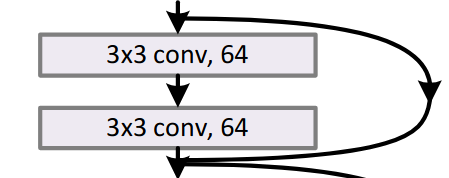

No way we can write this using `keras.Sequential`, so lets's break out the [functional API](https://keras.io/guides/functional_api/).
This is an implementation of such a block:

In [ ]:
from keras import layers

def resnet_block(x, filters, stride):

    # A variable to keep the original input.
    shortcut = x

    # First part: 3x3 convolutions, with 64 filters. With increased
    # stride we get a downsampling of the resolution of the input, so
    # then there is no need for pooling layers (like MaxPool2D).
    # Then batch normalisation, and the activation function.
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=stride, padding="same")(x)
    x = layers.BatchNormalization(epsilon=1.001e-5)(x)
    x = layers.Activation("relu")(x)

    # Same once more, but we need to set padding='same' in order
    # for the shapes tp match when we sum the branches.
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = layers.BatchNormalization(epsilon=1.001e-5)(x)
    x = layers.Activation("relu")(x)

    # A convolution where the filter is the size of a single pixel??
    x = layers.Conv2D(4 * filters, kernel_size=1)(x)
    x = layers.BatchNormalization(epsilon=1.001e-5)(x)

    # Since we have downsampled the resolution of `x`, we also need
    # to downsample the resolution of `shortcut`, so that they both
    # have the same resolution (same size). Otherwise we can't
    # add them together.
    shortcut = layers.Conv2D(4 * filters, kernel_size=1, strides=stride)(shortcut)
    shortcut = layers.BatchNormalization(epsilon=1.001e-5)(shortcut)

    # Finally, sum the output of the layers with the original input
    x = layers.Add()([shortcut, x])

    # Apply the activation function, and we're done.
    x = layers.Activation("relu")(x)

    return x

A lot of stuff going on here, so try and see if can convince yourself that we reproduce the simple fogure above, but in a way where all the output shapes make sense.

The trick of applying convolutional layers with `kernel_size=1` is kind of special, but in many cases very useful. Since it doesn't look at neighbouring pixels, it's not really a convolution anymore, but it still does the summing over all channels (recall lecture 3). In effect it makes a weighed average over all input channels, and allows us to adjust the number of output channels. In our case, we need the number of channels to match between `x` and `shortcut`.

For more detail about these 1x1 convolutions, have a look at [this](https://machinelearningmastery.com/introduction-to-1x1-convolutions-to-reduce-the-complexity-of-convolutional-neural-networks/) nice tutorial.

Now, let't put together the building blocks into an actual network. First we start simple, with three identical blocks:

In [ ]:
def build_simple_resnet(input_shape, num_classes=10, name='ResNet'):

    # The mandatory input layer.
    img_input = layers.Input(shape=input_shape)

    # Initial conv layer
    x = layers.Conv2D(64, 3, strides=2, padding='same')(img_input)

    # Stack the residual blocks.
    x = resnet_block(x, filters=64, stride=2)
    x = resnet_block(x, filters=64, stride=1)
    x = resnet_block(x, filters=64, stride=1)

    # After all the convolutions, add global average pooling
    # (see the documentation for a description of it)
    x = layers.GlobalAveragePooling2D()(x)

    # Finally -- add a Dense layer to perform the classification.
    x = layers.Dense(num_classes, activation='softmax')(x)

    # Some regularisation can be nice
    x = layers.Dropout(0.5)(x)

    # Create the Model instance
    model = keras.Model(inputs=img_input, outputs=x)

    return model

Does it look like expected?

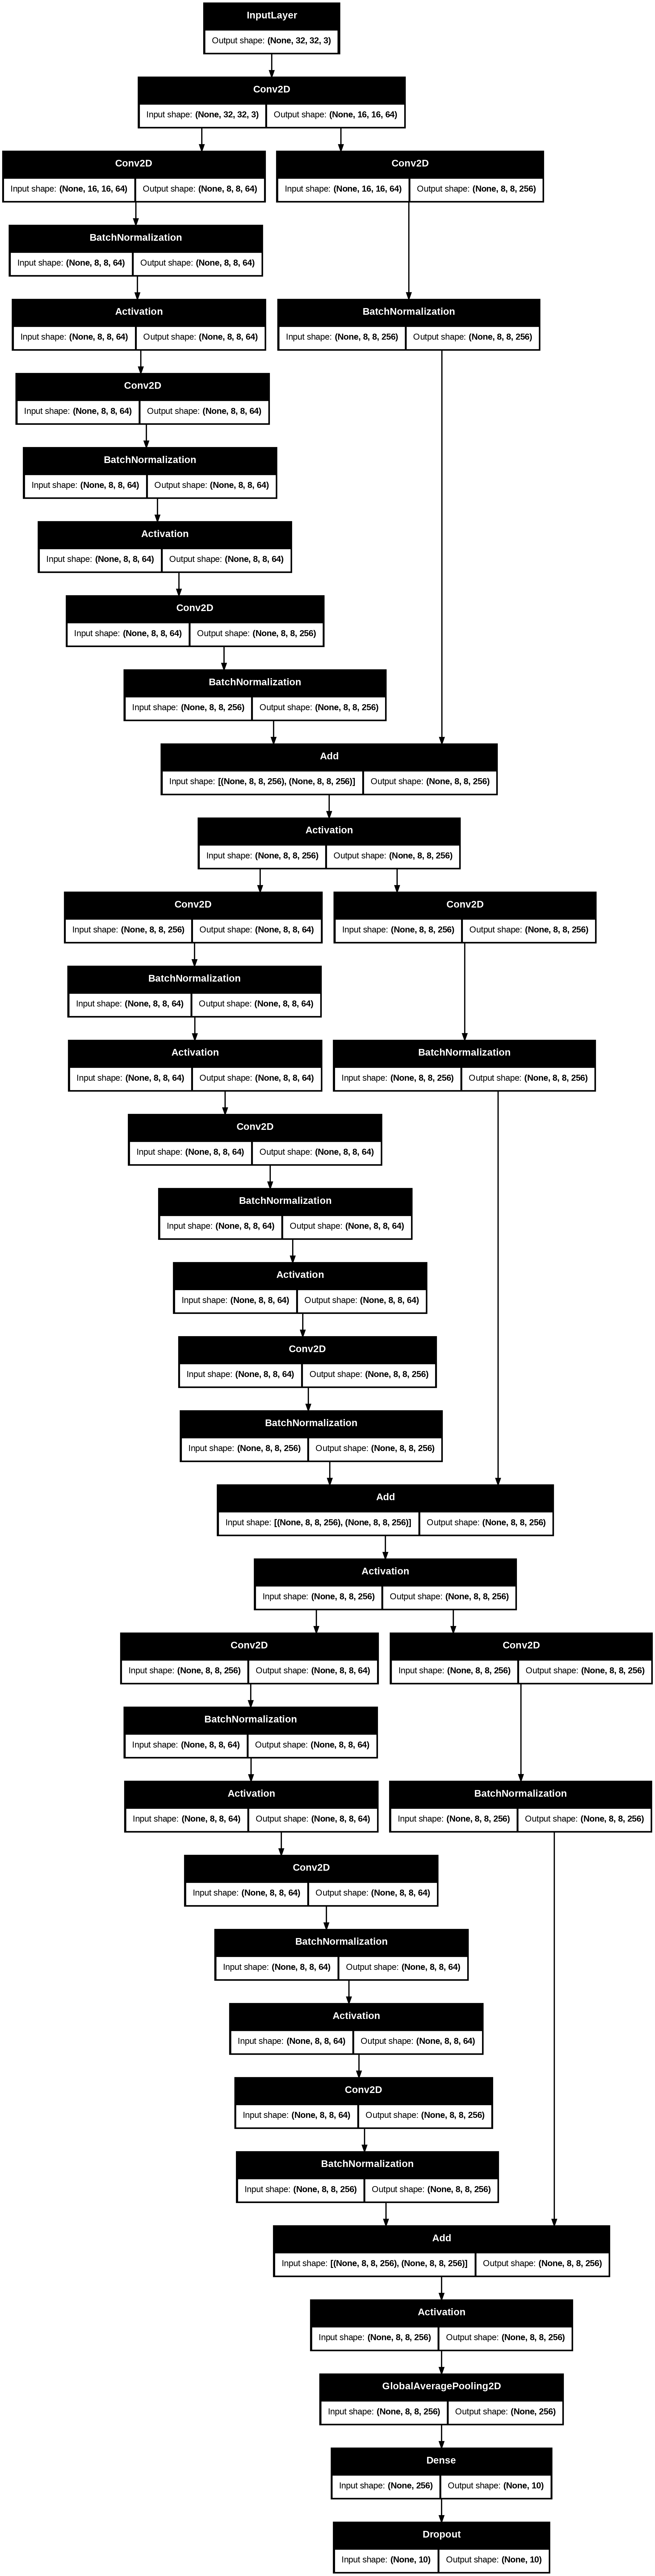

In [ ]:
resnet_simple = build_simple_resnet(image_shape, name="Simple_ResNet")

keras.utils.plot_model(resnet_simple, show_shapes=True)

Time for some training.

In [ ]:
resnet_simple.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

resnet_simple.fit(
    X_train, y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_test, y_test),
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.2611 - loss: nan - val_accuracy: 0.4007 - val_loss: 1.7309
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3454 - loss: nan - val_accuracy: 0.4224 - val_loss: 1.7702
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.3702 - loss: nan - val_accuracy: 0.4683 - val_loss: 1.5787
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3872 - loss: nan - val_accuracy: 0.5015 - val_loss: 1.5260
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3979 - loss: nan - val_accuracy: 0.5327 - val_loss: 1.4289
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4112 - loss: nan - val_accuracy: 0.6101 - val_loss: 1.1906
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4207 - loss: nan - val_accuracy: 0.5578 - val_loss: 1.2960
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.4234 - loss: nan - val_accuracy: 0.6609 - val_lo

Plot some predictions, and see if we agree:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


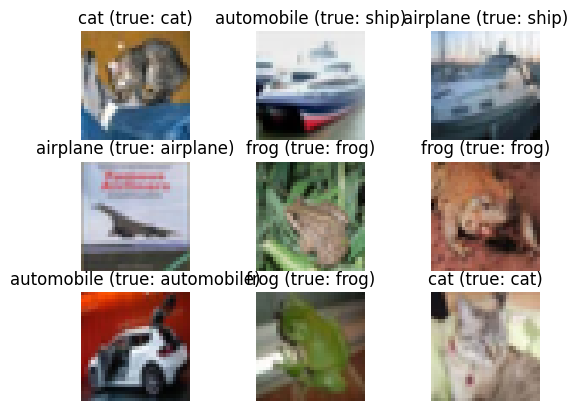

In [ ]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

preds = resnet_simple.predict(X_test[:9])

_, ax = plt.subplots(nrows=3, ncols=3)
for i in range(9):
    label_number = np.argmax(y_test[i])
    pred_label_number = np.argmax(preds[i])
    ax[i // 3, i % 3].imshow(X_test[i])
    ax[i // 3, i % 3].set_title(f'{label_names[pred_label_number]} (true: {label_names[label_number]})')
    ax[i // 3, i % 3].axis("off")

### <span style="color: red; font-weight: bold;">Exercise:<span>

_Your turn:_ Now we will try reproducing one of the experiments from the ResNet paper.

Create a ResNet-type model which has:
- 6 residual blocks with 16 filters, where the resolution is 32x32 pixels
- 6 residual blocks with 32 filters, resolution 16x16
- 6 residual blocks with 64 filters, resolution 8x8

Then train it. If you find it to overfit, consider adding L2 ("weight decay") regularisation with a penalty of 0.0001.

In [ ]:
def build_resnet(input_shape, num_classes=10, name='ResNet'):

    # The mandatory input layer.
    img_input = layers.Input(shape=input_shape)

    # First layer (can keep this)
    x = layers.Conv2D(64, 3, strides=2, padding='same')(img_input)

    # Now you do the rest!
    # Bring back to 32x32 so we can match the exercise spec
    x = layers.UpSampling2D(size=(2, 2))(x)                         # 16x16 -> 32x32

    # Optional: stabilize
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # ---- Stage 1: 6 residual blocks, 16 filters, 32x32 ----
    # First adapt channels from 64 -> 16
    x = layers.Conv2D(16, 1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    for _ in range(6):
        x = resnet_block(x, filters=16, stride=1)

    # ---- Stage 2: 6 residual blocks, 32 filters, 16x16 ----
    x = resnet_block(x, filters=32, stride=2)  # downsample 32->16
    for _ in range(5):
        x = resnet_block(x, filters=32, stride=1)

    # ---- Stage 3: 6 residual blocks, 64 filters, 8x8 ----
    x = resnet_block(x, filters=64, stride=2)  # downsample 16->8
    for _ in range(5):
        x = resnet_block(x, filters=64, stride=1)

    # ---- Head ----
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(img_input, outputs, name=name)

    return model

Train, then marvel at your own success.

In [ ]:
resnet = build_resnet(image_shape, name="BetterResNet")

resnet.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

resnet.fit(
    X_train, y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_test, y_test),
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 156s 224ms/step - accuracy: 0.2626 - loss: 1.9678 - val_accuracy: 0.2982 - val_loss: 1.9264
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 147ms/step - accuracy: 0.4641 - loss: 1.4561 - val_accuracy: 0.3626 - val_loss: 2.0099
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 56s 144ms/step - accuracy: 0.5511 - loss: 1.2408 - val_accuracy: 0.4130 - val_loss: 1.9881
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 56s 144ms/step - accuracy: 0.6239 - loss: 1.0561 - val_accuracy: 0.5001 - val_loss: 1.5925
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 56s 144ms/step - accuracy: 0.6819 - loss: 0.8999 - val_accuracy: 0.5848 - val_loss: 1.2921
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 56s 144ms/step - accuracy: 0.7314 - loss: 0.7628 - val_accuracy: 0.6254 - val_loss: 1.1074
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 56s 144ms/step - accuracy: 0.7693 - loss: 0.6548 - val_accuracy: 0.6733 - val_loss: 0.9649
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 56s 144ms/step - accuracy: 0.8023 - loss: 

## Inception networks

A different noteworthy architecture is called _Inception_, and is based on blocks that look like this:

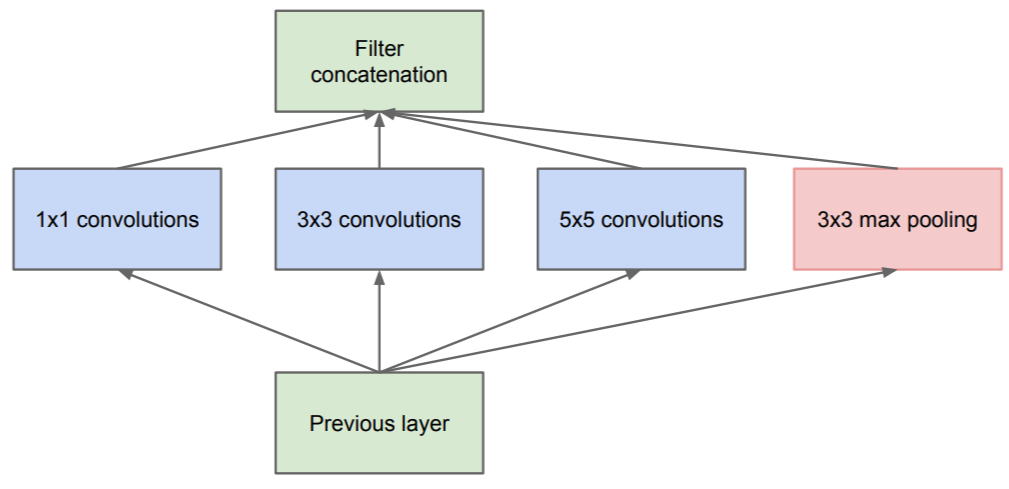

By combining the results from differently sized convolution, the idea is to capture image features of different spatial structure in each layer. For a more thorough description, have a look at the research [paper](https://arxiv.org/pdf/1409.4842). There are several iterations on the details of the architecture, but for simplicity we try to implement the original.

Again, it is useful to take a modular approach and write a function that creates a single block.

### <span style="color: red; font-weight: bold;">Exercise:<span>

Write a function that creates an Inception module.

Hint: You might want something that ends with
```
x = layers.concatenate(
    [branch1x1, branch5x5, branch3x3, branch_pool]
)
```

In [ ]:
def inception_block(x, filter_list=[16, 32, 8]):

  f1, f3, f5 = filter_list

    # 1x1 branch
  branch1x1 = layers.Conv2D(filter_list[0], (1, 1), padding="same", activation="relu")(x)

    # 3x3 branch
  branch3x3 = layers.Conv2D(filter_list[1], (3, 3), padding="same", activation="relu")(x)

    # 5x5 branch
  branch5x5 = layers.Conv2D(filter_list[2], (5, 5), padding="same", activation="relu")(x)

    # Pooling branch
  branch_pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding="same")(x)
  branch_pool = layers.Conv2D(filter_list[0], (1, 1), padding="same", activation="relu")(branch_pool)

    # Concatenate (som i hintet)
  x = layers.concatenate(
      [branch1x1, branch5x5, branch3x3, branch_pool]
    )


  return x

With the module function in place, we can write the rest of the network. If you look at the figures in the article, their final model is huge (and also designed for higher-resolution images than what we use here), so let's aim for a smaller version.

### <span style="color: red; font-weight: bold;">Exercise:<span>


Make a complete Inception network, that contains (in order)

- a 3x3 convolution with 64 filters, stride 1, "valid" padding
- one Inception module, with
    - 16 1x1 filters
    - 32 3x3 filters
    - 8 5x5 filters
- a pooling layer with pool size 2
- two Inception modules, same settings as above
- a pooling layer with pool size 2
- one Inception module, same settings as above
- global average pooling layer
- dropout layer
- classification layer

In [ ]:
def build_inception_net(input_shape):

    # ...
  num_classes = 10
  inputs = layers.Input(shape=input_shape)

  x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding="valid", activation="relu")(inputs)

  x = inception_block(x, filter_list=[16, 32, 8])

  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

  x = inception_block(x, filter_list=[16, 32, 8])
  x = inception_block(x, filter_list=[16, 32, 8])

  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

  x = inception_block(x, filter_list=[16, 32, 8])

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.4)(x)

  outputs = layers.Dense(num_classes, activation="softmax")(x)

    # ...
  model = keras.Model(inputs=inputs, outputs=outputs, name="InceptionNet")

  return model

In [ ]:
model = build_inception_net(image_shape)

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.2407 - loss: 2.7364 - val_accuracy: 0.4606 - val_loss: 1.4636
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.4454 - loss: 1.5173 - val_accuracy: 0.5382 - val_loss: 1.2548
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5173 - loss: 1.3331 - val_accuracy: 0.5586 - val_loss: 1.2259
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5683 - loss: 1.2038 - val_accuracy: 0.6486 - val_loss: 1.0016
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.6145 - loss: 1.0915 - val_accuracy: 0.6700 - val_loss: 0.9502
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.6428 - loss: 1.0191 - val_accuracy: 0.6883 - val_loss: 0.8951
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.6585 - loss: 0.9736 - val_accuracy: 0.6997 - val_loss: 0.8871
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.6717 -

### Improving the Inception network

By now you might have figured out that the name of this network type comes from the fact that we have _networks inside of networks_. This generelly leads to a lot of parameters, but we can make more efficient modules by adding the 1x1 convolution trick, that we also used for the ResNet modules. The article suggests this layout:

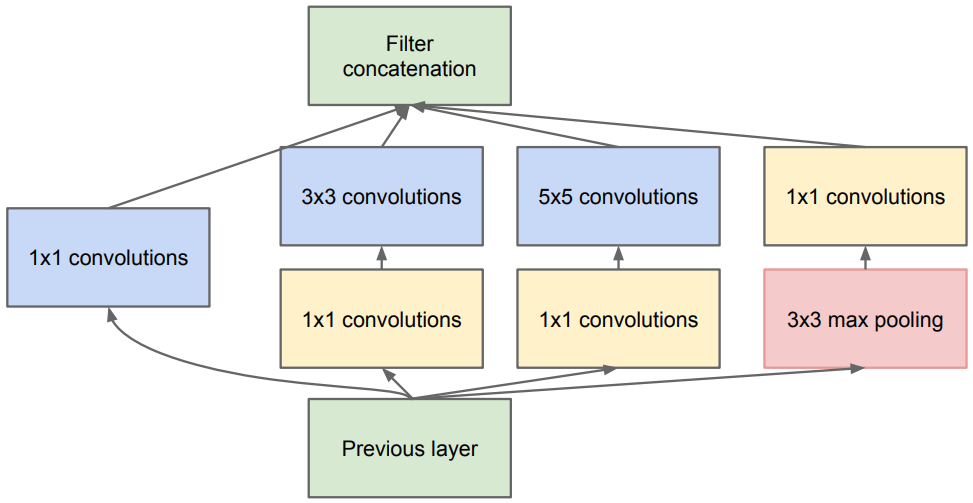

### <span style="color: red; font-weight: bold;">Exercise:<span>


Add these 1x1 convolution layers to your model, so that they reduce the number of channels to **half**, and train it. Now you can probably double the number of Inception layers -- try it out!

In [ ]:
def build_improved_inception_net(input_shape):

    # ...
  num_classes = 10
  inputs = layers.Input(shape=input_shape)

  x = layers.Conv2D(64, (3, 3), strides=1, padding="valid", activation="relu")(inputs)

  x = improved_inception_block(x, filter_list=(16, 32, 8))
  x = improved_inception_block(x, filter_list=(16, 32, 8))
  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Stage B
  x = improved_inception_block(x, filter_list=(16, 32, 8))
  x = improved_inception_block(x, filter_list=(16, 32, 8))
  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Stage C
  x = improved_inception_block(x, filter_list=(16, 32, 8))
  x = improved_inception_block(x, filter_list=(16, 32, 8))

    # Head
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(num_classes, activation="softmax")(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name="ImprovedInceptionNet")


  return model

Finally, plot some of our predictions:

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


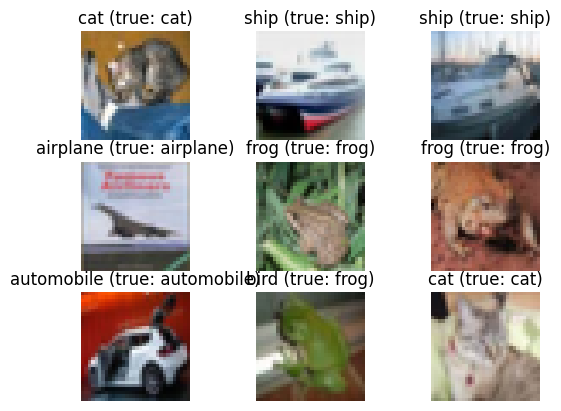

In [ ]:
preds = model.predict(X_test[:9])

_, ax = plt.subplots(nrows=3, ncols=3)
for i in range(9):
    label_number = np.argmax(y_test[i])
    pred_label_number = np.argmax(preds[i])
    ax[i // 3, i % 3].imshow(X_test[i])
    ax[i // 3, i % 3].set_title(f'{label_names[pred_label_number]} (true: {label_names[label_number]})')
    ax[i // 3, i % 3].axis("off")